In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from data.utils import list_data, get_data
from metrics.accuracy import compare_accuracy
from metrics.calibration_scalar import compare_calibration

from treeffuser import LightGBMTreeffuser
from ngboost import NGBRegressor

## Data

In [3]:
list_data()

{'naval': 'data/uci/naval',
 'protein': 'data/uci/protein',
 'wine': 'data/uci/wine',
 'yacht': 'data/uci/yacht'}

## Models

In [4]:
N_SAMPLES = 64

for data_name in ["protein"]:
    data = get_data(data_name, verbose=True)
    # only take 1000 samples
    data["x"] = data["x"][:1000]
    data["y"] = data["y"][:1000]

    X_train, X_test, y_train, y_test = train_test_split(
        data["x"], data["y"], test_size=0.2, random_state=42
    )

    models = {}
    preds = {}
    samples = {}

    for sde_name in ["vesde"]: # ["vpsde", "vesde", "sub-vpsde"]:
        model = LightGBMTreeffuser(
            verbose=1,
            n_repeats=100,
            n_estimators=10000,
            sde_name=sde_name,
            learning_rate=0.01,
            early_stopping_rounds=50,
            num_leaves=31,
        )
        temp = model.fit(
            X_train, y_train
        )
        y_samples = model.sample(
            X_test, n_samples=N_SAMPLES, n_parallel=8, n_steps=100, seed=0, verbose=1,
        )
        model_name = f"treeffuser_{sde_name}"
        models[model_name] = model
        preds[model_name] = y_samples.mean(axis=0)
        samples[model_name] = y_samples

    model_name = "ngb"
    model = NGBRegressor(early_stopping_rounds=50)
    model.fit(X_train, y_train)
    models[model_name] = model
    y_dim = data["y"].shape[1]
    preds[model_name] = model.predict(X_test).reshape((-1, y_dim))
    y_samples = model.pred_dist(X_test).sample(N_SAMPLES)
    samples[model_name] = y_samples

    metrics_accuracy = compare_accuracy(preds, y_test, print_table=False)
    metrics_calibration = compare_calibration(samples, y_test)

    # merge metrics
    metrics = pd.concat([pd.DataFrame(metrics_accuracy), pd.DataFrame(metrics_calibration)], axis=0)

    break

metrics

Getting protein dataset.
# of observations: 45730, # of covariates: 9, dimension of outcome: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 11
[LightGBM] [Info] Start training from score -0.001976
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l2: 0.419055


100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=3.2380 val_loss=3.2267 scale=1.0000 norm=5.5660
[iter 100] loss=2.9384 val_loss=3.0832 scale=2.0000 norm=8.1550
== Early stopping achieved.
== Best iteration / VAL108 (val_loss=3.0788)


,treeffuser_vesde,ngb
mae,3.700152,4.127261
rmse,5.216762,5.080572
mdae,2.395408,3.568576
marpd,50.285109,59.316123
r2,0.325297,0.360065
corr,0.590821,0.607040
sharpness,2.643518,4.792457
rmsce,0.114313,0.054254
mace,0.098164,0.042499
adversarial_mace_0.1,0.217599,0.200029


0.09816425879396984
0.0424992148241206


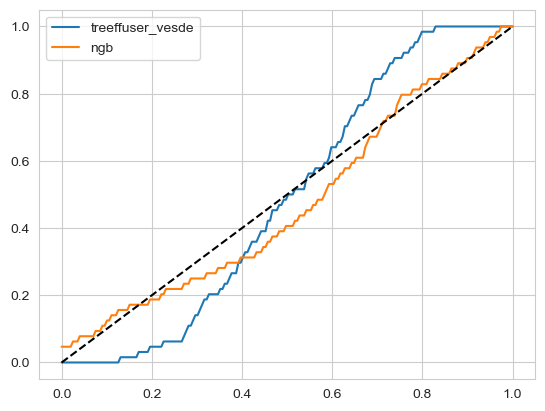

In [5]:
from matplotlib import pyplot as plt

for label in ["treeffuser_vesde", "ngb"]:
    quantiles = []
    for i in range(y_test.shape[0]):
        y_true_i = y_test[i][0]
        quantile = np.mean(samples[label][:,i] <= y_true_i)
        quantiles.append(quantile)

    quantiles = np.sort(quantiles)
    x = np.linspace(0, 1, y_test.shape[0])
    print(np.abs(quantiles - x).mean())
    plt.plot(x, quantiles, label=label)
plt.plot(x, x, linestyle='--', color='black')
plt.legend()
plt.show()

In [6]:
metrics_accuracy = compare_accuracy(preds, y_test, print_table=False)
metrics_calibration = compare_calibration(samples, y_test)

# merge metrics
metrics = pd.concat([pd.DataFrame(metrics_accuracy), pd.DataFrame(metrics_calibration)], axis=0)

In [7]:
metrics

,treeffuser_vesde,ngb
mae,3.700152,4.127261
rmse,5.216762,5.080572
mdae,2.395408,3.568576
marpd,50.285109,59.316123
r2,0.325297,0.360065
corr,0.590821,0.607040
sharpness,2.643518,4.792457
rmsce,0.114313,0.054254
mace,0.098164,0.042499
adversarial_mace_0.1,0.217599,0.200029


# V data

In [8]:
n = 1000
X_train1 = np.random.rand(n, 1)
y_train1 = X_train1 + np.random.randn(n, 1) * 0.05 * (X_train1 + 1) ** 2

X_train2 = np.random.rand(n, 1)
y_train2 = - X_train2 + np.random.randn(n, 1) * 0.05 * (X_train2 + 1)**2


X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [9]:
N_SAMPLES = 256

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

model = {}
preds = {}
samples = {}

for sde_name in ["vesde"]: # ["vpsde", "vesde", "sub-vpsde"]:
    model = LightGBMTreeffuser(
        verbose=1,
        n_repeats=100,
        n_estimators=1000,
        sde_name=sde_name,
        learning_rate=0.1,
        early_stopping_rounds=50,
        num_leaves=31,
    )
    temp = model.fit(
        X_train, y_train
    )
    y_samples = model.sample(
        X_test, n_samples=N_SAMPLES, n_parallel=8, n_steps=30, seed=0, verbose=1,
    )
    model_name = f"treeffuser_{sde_name}"
    preds[model_name] = y_samples.mean(axis=0)
    samples[model_name] = y_samples

model_name = "ngb"
model = NGBRegressor(early_stopping_rounds=50)
model.fit(X_train, y_train)
y_dim = data["y"].shape[1]
preds[model_name] = model.predict(X_test).reshape((-1, y_dim))
y_samples = model.pred_dist(X_test).sample(N_SAMPLES)
samples[model_name] = y_samples

metrics_accuracy = compare_accuracy(preds, y_test, print_table=False)
metrics_calibration = compare_calibration(samples, y_test)

# merge metrics
metrics = pd.concat([pd.DataFrame(metrics_accuracy), pd.DataFrame(metrics_calibration)], axis=0)

metrics

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 3
[LightGBM] [Info] Start training from score 0.000639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid_0's l2: 0.425069


100%|██████████| 256/256 [00:02<00:00, 115.48it/s]
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=0.8921 val_loss=0.9117 scale=2.0000 norm=1.3970
[iter 100] loss=0.5951 val_loss=0.6432 scale=2.0000 norm=1.1667
[iter 200] loss=0.5012 val_loss=0.5551 scale=2.0000 norm=1.1164
[iter 300] loss=0.4685 val_loss=0.5457 scale=2.0000 norm=1.1091
== Early stopping achieved.
== Best iteration / VAL279 (val_loss=0.5436)


,treeffuser_vesde,ngb
mae,0.516458,0.509560
rmse,0.618686,0.622440
mdae,0.502799,0.483179
marpd,178.050466,182.094383
r2,-0.035854,-0.048462
corr,-0.014808,0.020603
sharpness,0.580140,0.535041
rmsce,0.027148,0.099521
mace,0.024076,0.080806
adversarial_mace_0.1,0.132983,0.153127


0.024075936912594003
0.08080611685463658


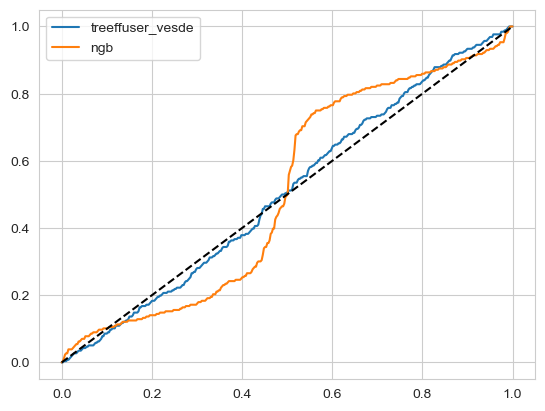

In [10]:
from matplotlib import pyplot as plt

for label in ["treeffuser_vesde", "ngb"]:
    quantiles = []
    for i in range(y_test.shape[0]):
        y_true_i = y_test[i][0]
        quantile = np.mean(samples[label][:,i] <= y_true_i)
        quantiles.append(quantile)

    quantiles = np.sort(quantiles)
    x = np.linspace(0, 1, y_test.shape[0])
    print(np.abs(quantiles - x).mean())
    plt.plot(x, quantiles, label=label)
plt.plot(x, x, linestyle='--', color='black')

plt.legend()

/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

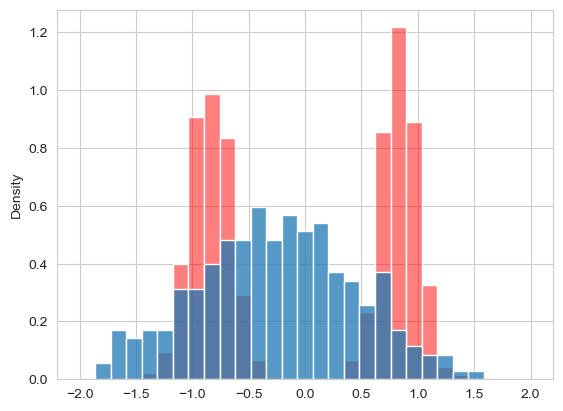

In [16]:
import seaborn as sns

idx = 2
x = X_test[idx]

n_bins = 30
_n = 1000
y_bins = np.linspace(-2, 2, n_bins)
ground_truth = x*(np.random.binomial(1, 0.5, _n) - 0.5)*2 + np.random.randn(_n) * 0.05 * (x + 1) ** 2
sns.histplot(ground_truth, bins=y_bins, color='red', alpha=0.5, stat='density')

sns.histplot(samples["ngb"][:,idx].squeeze(), bins=y_bins, stat='density')
# sns.histplot(samples["treeffuser_vesde"][:,idx].squeeze(), bins=np.linspace(-1, 1, n_bins), stat='density')



# Simulated calibration curve

In [12]:
ground_truth_x = np.random.uniform(-10, 10, 200)
ground_truth_y = np.random.normal(ground_truth_x, 1)
overconfident_model_y = np.random.normal(ground_truth_x, 0.2, size=(1000, ground_truth_x.shape[0]))
underconfident_model_y = np.random.normal(ground_truth_x, 2, size=(1000,ground_truth_x.shape[0]))

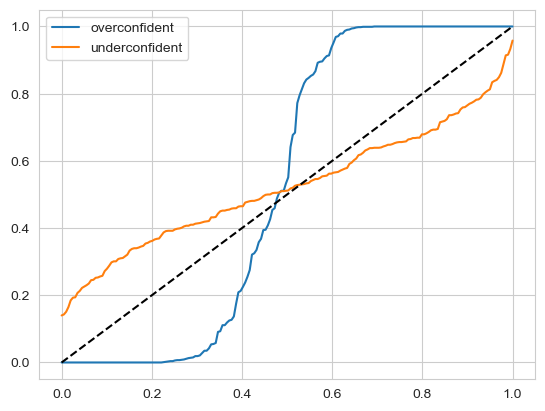

In [13]:
x = np.linspace(0, 1, ground_truth_y.shape[0])
for model_name, model_y in [("overconfident", overconfident_model_y), ("underconfident", underconfident_model_y)]:
    quantiles = []
    for i in range(ground_truth_y.shape[0]):
        ground_truth_y_i = ground_truth_y[i]
        quantile = np.mean(model_y[:,i] <= ground_truth_y_i)
        quantiles.append(quantile)

    quantiles = np.sort(quantiles)
    plt.plot(x, quantiles, label=model_name)

plt.plot(x, x, linestyle='--', color='black')
plt.legend()

# Linear DATA

In [8]:
import matplotlib.pyplot as plt


In [68]:
import numpy as np


n = 2000
X = np.random.rand(n, 1) * 20
y_mean = X * np.sin(X * 4)
y_std = 3 * np.sin(0.4 * (X + 1)**2) ** 2
y = np.random.randn(n, 1) * y_std + y_mean


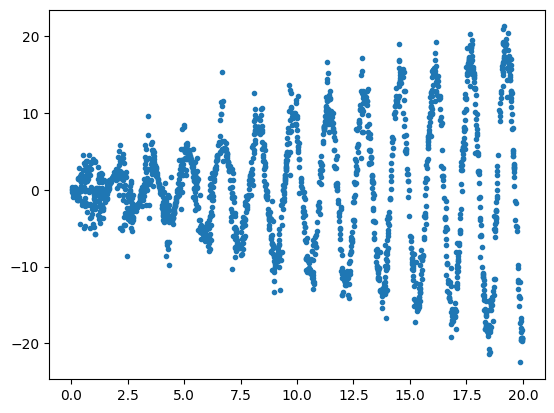

In [69]:
plt.plot(X, y, '.')

In [70]:
N_SAMPLES = 256

train_n = int(X.shape[0] * 0.8)
X_train = X[:train_n]
y_train = y[:train_n]
X_test = X[train_n:]
y_test = y[train_n:]
y_test_mean = y_mean[train_n:]
y_test_std = y_std[train_n:]

model = {}
preds = {}
samples = {}

for sde_name in ["vesde"]: # ["vpsde", "vesde", "sub-vpsde"]:
    model = LightGBMTreeffuser(
        verbose=1,
        n_repeats=100,
        n_estimators=1000,
        sde_name=sde_name,
        learning_rate=0.1,
        early_stopping_rounds=50,
        num_leaves=31,
    )
    temp = model.fit(
        X_train, y_train
    )
    y_samples = model.sample(
        X_test, n_samples=N_SAMPLES, n_parallel=8, n_steps=30, seed=0, verbose=1,
    )
    model_name = f"treeffuser_{sde_name}"
    preds[model_name] = y_samples.mean(axis=0)
    samples[model_name] = y_samples

model_name = "ngb"
model = NGBRegressor(early_stopping_rounds=50)
model.fit(X_train, y_train)
y_dim = 1
preds[model_name] = model.predict(X_test).reshape((-1, y_dim))
y_samples = model.pred_dist(X_test).sample(N_SAMPLES)
samples[model_name] = y_samples

metrics_accuracy = compare_accuracy(preds, y_test, print_table=False)
metrics_calibration = compare_calibration(samples, y_test)

# merge metrics
metrics = pd.concat([pd.DataFrame(metrics_accuracy), pd.DataFrame(metrics_calibration)], axis=0)

metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 3
[LightGBM] [Info] Start training from score -0.001737
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 0.295907


100%|██████████| 256/256 [00:38<00:00,  6.58it/s]
/Users/nicolasvelezbeltran/phd/projects/semester_2/diffusion-trees/tree-diffuser/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolasvelezbeltran/phd/projects/semester_2/diffusion-trees/tree-diffuser/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=3.5654 val_loss=3.5807 scale=2.0000 norm=13.5993
[iter 100] loss=3.1262 val_loss=3.1464 scale=2.0000 norm=10.1547
[iter 200] loss=2.9002 val_loss=2.9044 scale=1.0000 norm=4.1091
[iter 300] loss=2.7220 val_loss=2.7244 scale=2.0000 norm=6.8975
[iter 400] loss=2.5904 val_loss=2.6003 scale=2.0000 norm=5.9972


,treeffuser_vesde,ngb
mae,1.610296,2.668715
rmse,2.300734,3.316576
mdae,1.133483,2.263400
marpd,47.794503,93.195621
r2,0.922329,0.838598
corr,0.961410,0.933470
sharpness,2.112668,3.469258
rmsce,0.055868,0.025191
mace,0.049914,0.020608
adversarial_mace_0.1,0.141228,0.115946


<Axes: ylabel='Count'>

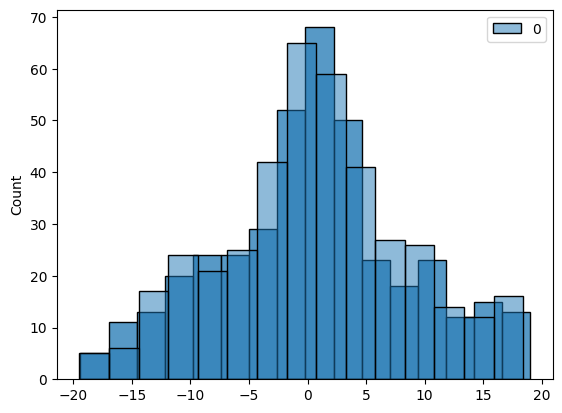

In [79]:
sns.histplot(y_test_mean_sorted.squeeze())
sns.histplot(treff_mean)




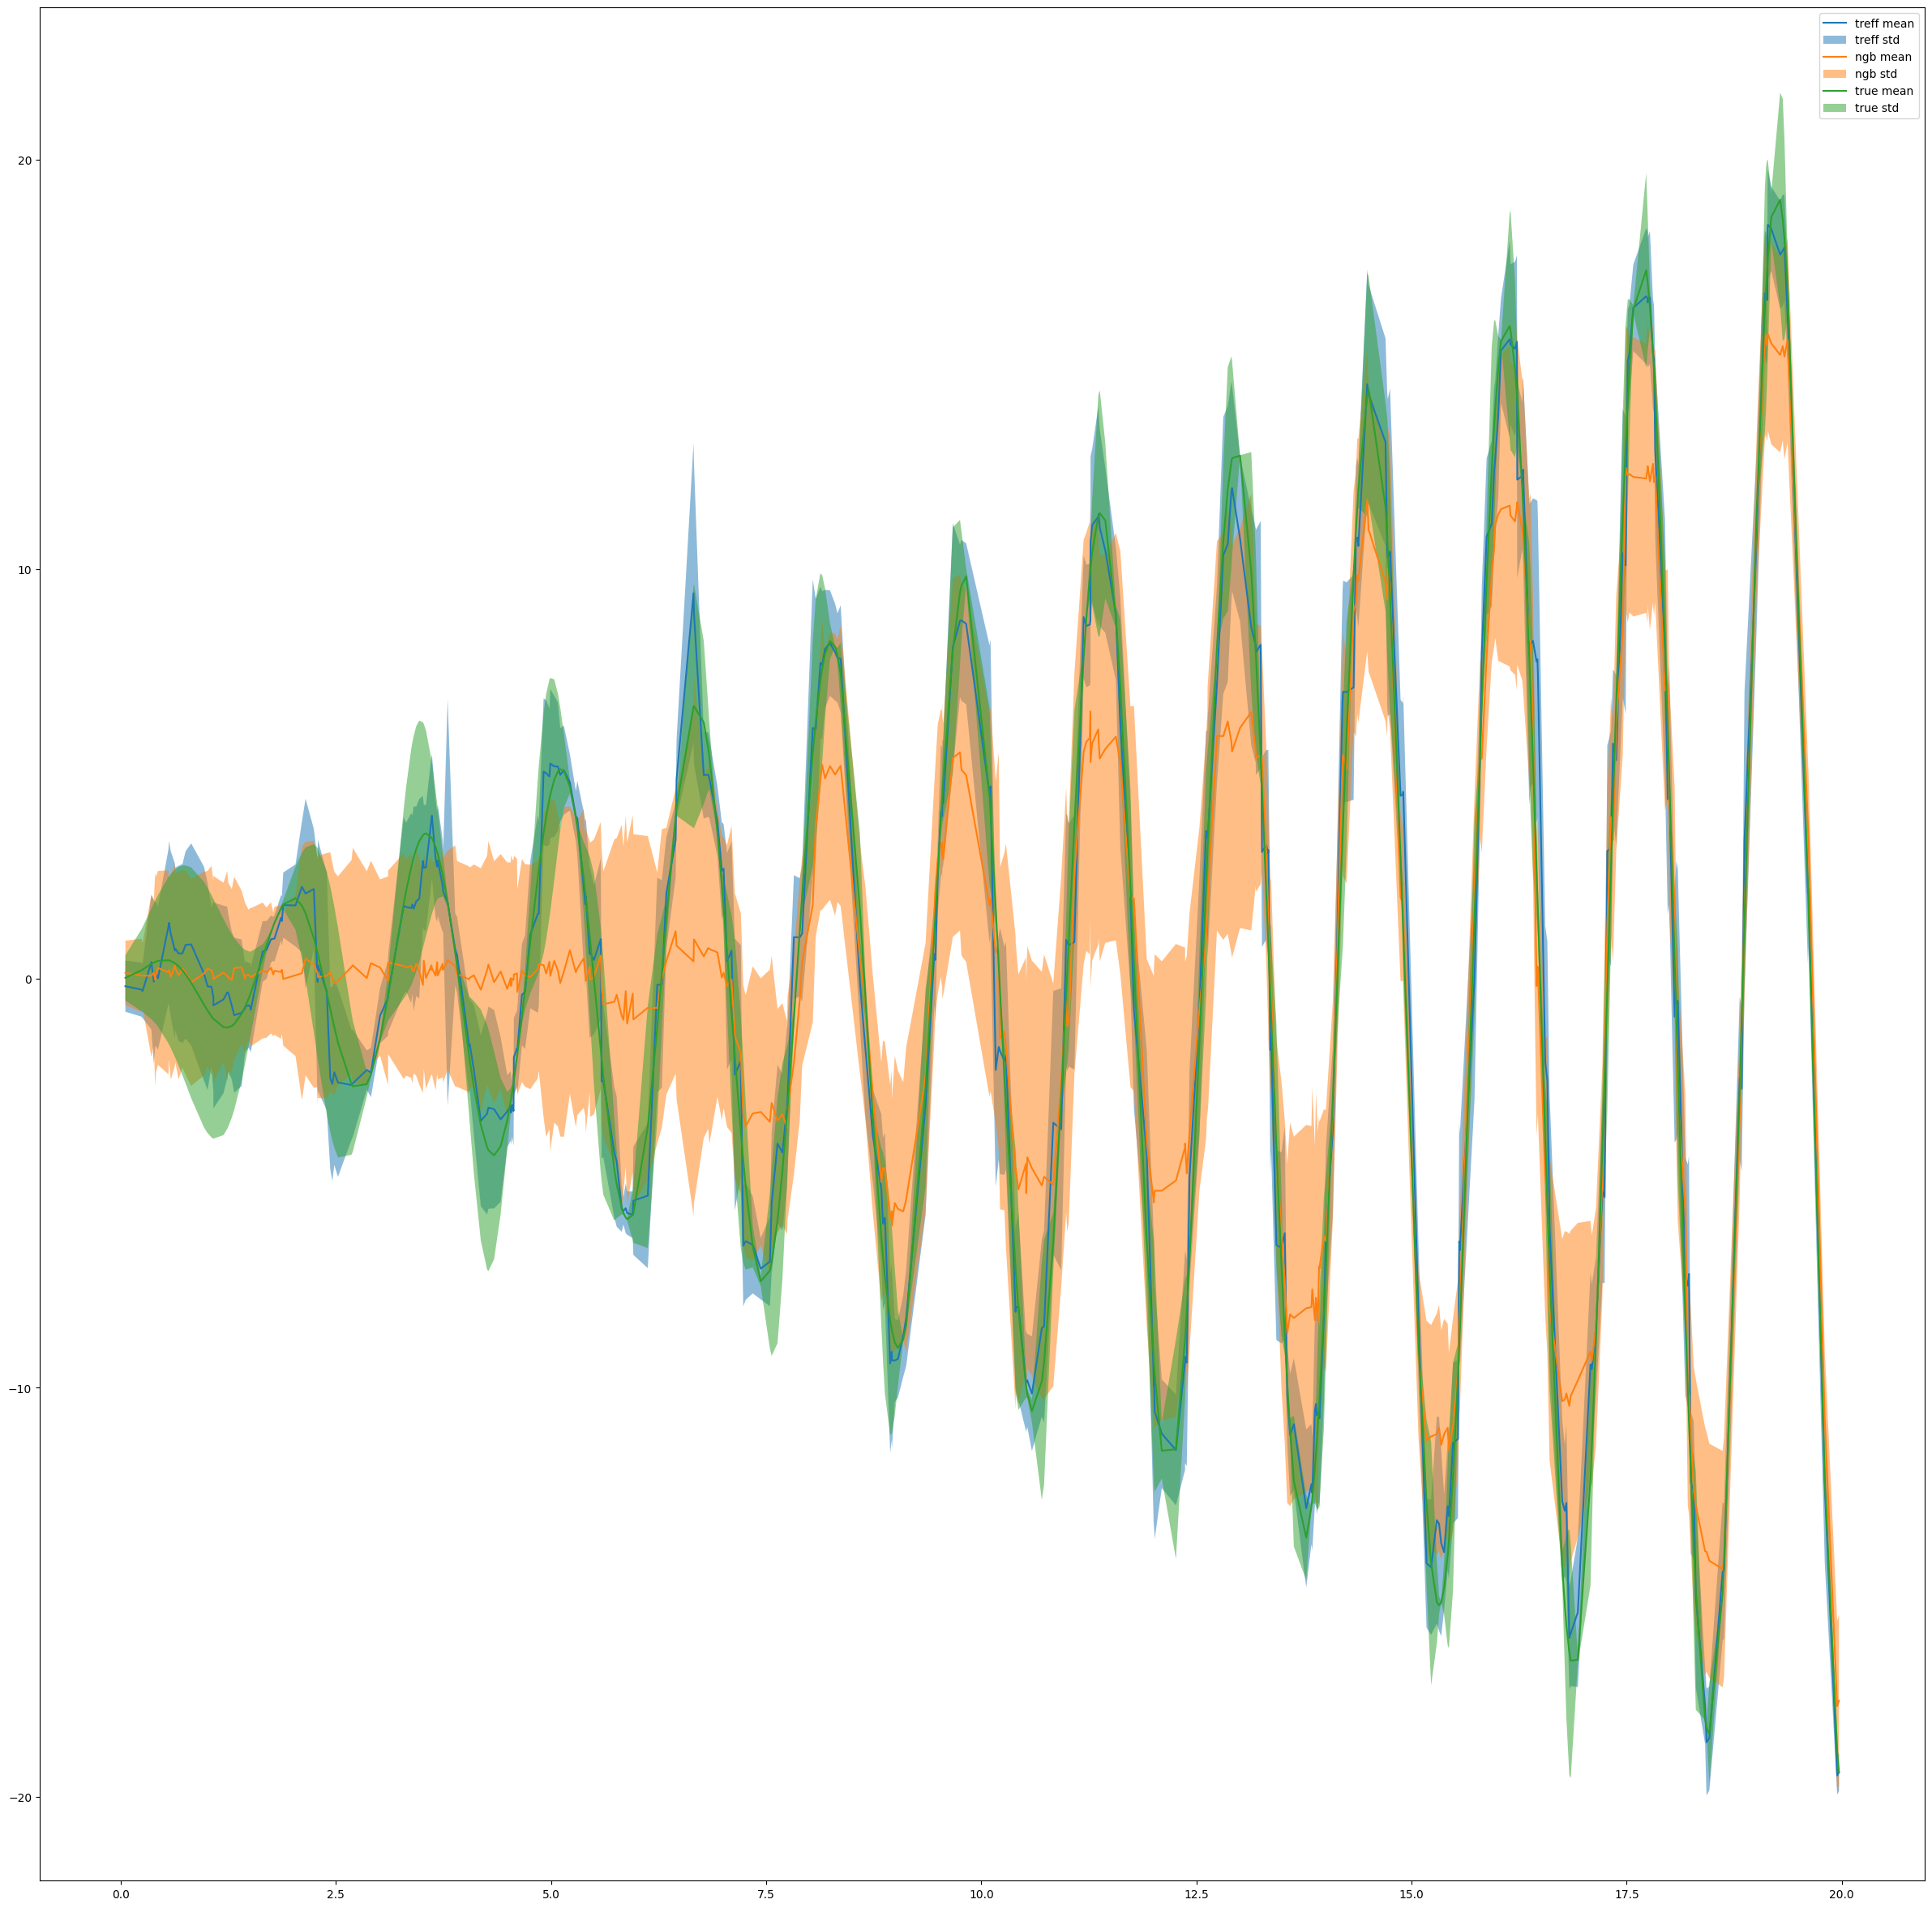

In [72]:
# Plot the true mean and std the ngb mean and std and the treeffuser mean and std
# make the plot large enough
plt.figure(figsize=(30, 30))

sort_idx = np.argsort(X_test.squeeze())
X_test_sorted = X_test[sort_idx]

treff_mean = samples["treeffuser_vesde"].mean(axis=0)
treff_mean_std = samples["treeffuser_vesde"].std(axis=0)
treff_mean = treff_mean[sort_idx]
treff_mean_std = treff_mean_std[sort_idx]

ngb_mean = samples["ngb"].mean(axis=0)
ngb_mean_std = samples["ngb"].std(axis=0)
ngb_mean = ngb_mean[sort_idx]
ngb_mean_std = ngb_mean_std[sort_idx]

y_test_mean_sorted = y_test_mean[sort_idx]
y_test_std_sorted = y_test_std[sort_idx]

plt.plot(X_test_sorted, treff_mean, label="treff mean")
plt.fill_between(X_test_sorted.squeeze(), treff_mean.squeeze() - treff_mean_std.squeeze(), treff_mean.squeeze() + treff_mean_std.squeeze(), alpha=0.5, label="treff std")
plt.plot(X_test_sorted, ngb_mean, label="ngb mean")
plt.fill_between(X_test_sorted.squeeze(), ngb_mean.squeeze() - ngb_mean_std.squeeze(), ngb_mean.squeeze() + ngb_mean_std.squeeze(), alpha=0.5, label="ngb std")
plt.plot(X_test_sorted, y_test_mean_sorted, label="true mean")
plt.fill_between(X_test_sorted.squeeze(), y_test_mean_sorted.squeeze() - y_test_std_sorted.squeeze(), y_test_mean_sorted.squeeze() + y_test_std_sorted.squeeze(), alpha=0.5, label="true std")
plt.legend()


plt.show()


In [ ]:
sns.histplot

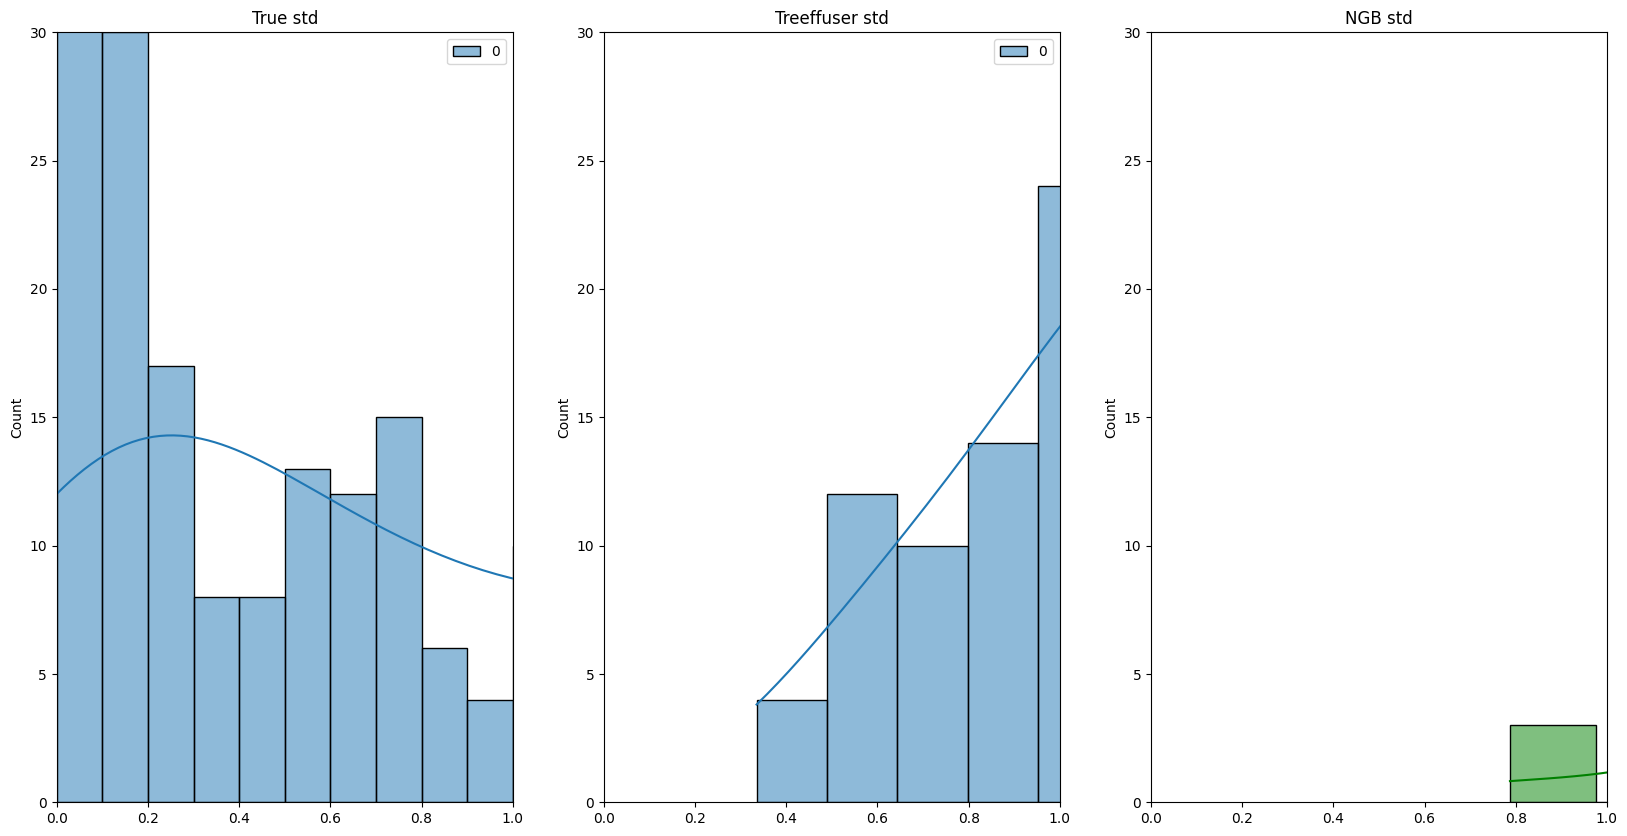

In [73]:
# Plot stds with seaborn on three different plots
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# plot the true std
sns.histplot(y_test_std, bins=30, kde=True, ax=ax[0], color="red")
ax[0].set_title("True std")

# plot the treff std
sns.histplot(samples["treeffuser_vesde"].std(axis=0), bins=30, kde=True, ax=ax[1], color="blue")
ax[1].set_title("Treeffuser std")

# plot the ngb std
sns.histplot(samples["ngb"].std(axis=0), bins=30, kde=True, ax=ax[2], color="green")
ax[2].set_title("NGB std")

# set all axes to the same limits
for a in ax:
    a.set_xlim([0, 1])
    a.set_ylim([0, 30])








0.04991384711779447
0.02060752467105263


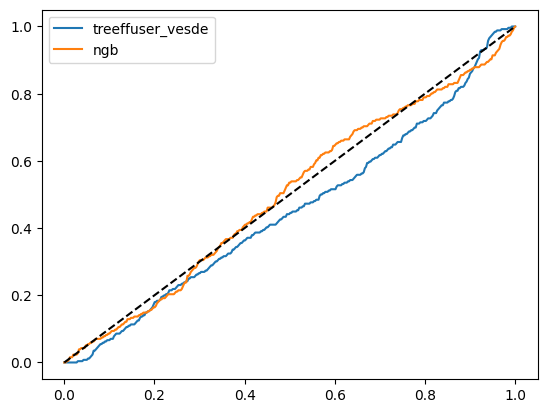

In [74]:
from matplotlib import pyplot as plt

for label in ["treeffuser_vesde", "ngb"]:
    quantiles = []
    for i in range(y_test.shape[0]):
        y_true_i = y_test[i][0]
        quantile = np.mean(samples[label][:,i] <= y_true_i)
        quantiles.append(quantile)

    quantiles = np.sort(quantiles)
    x = np.linspace(0, 1, y_test.shape[0])
    print(np.abs(quantiles - x).mean())
    plt.plot(x, quantiles, label=label)
plt.plot(x, x, linestyle='--', color='black')

plt.legend()

<Axes: ylabel='Density'>

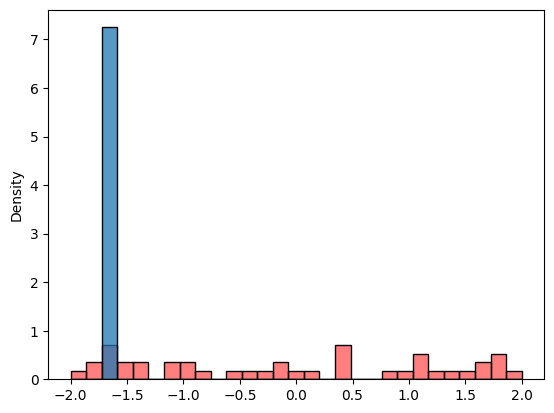

In [63]:
import seaborn as sns

idx = 2
x = X_test[idx]

n_bins = 30
_n = 1000
y_bins = np.linspace(-2, 2, n_bins)
ground_truth = x*(np.random.binomial(1, 0.5, _n) - 0.5)*2 + np.random.randn(_n) * 0.05 * (x + 1) ** 2
sns.histplot(ground_truth, bins=y_bins, color='red', alpha=0.5, stat='density')

sns.histplot(samples["ngb"][:,idx].squeeze(), bins=y_bins, stat='density')
# sns.histplot(samples["treeffuser_vesde"][:,idx].squeeze(), bins=np.linspace(-1, 1, n_bins), stat='density')

